### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

            
        if dataset == "benq":
            from_folder = "../gland_data"
        elif dataset == "ge":
            if mask_type == 1:
                from_folder = "../ge_data/nodule"
            else:
                from_folder = "../ge_data/gland"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type

In [5]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.9
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_train.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_test.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type = next(iter(test_dataloader))

In [6]:
from_dataset

tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2,
        2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
        1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 1, 1])

In [7]:
mask_type

tensor([1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1,
        1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1,
        2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2,
        2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2,
        1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1,
        2, 1, 1, 2, 1, 2])

In [8]:
print(len(train_dataset), len(test_dataset))

788 218


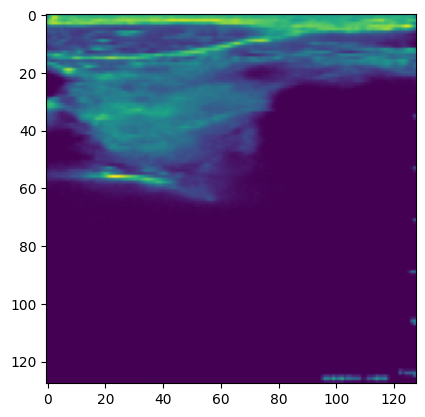

In [9]:
plt.imshow(image[18][0])

In [10]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue
        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count

    

In [11]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [12]:
# # freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [13]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [15]:

project = "thyroid_ge_benq_from_scratch"
name = "hybrid_model_ge(nodule_gland)_benq(gland)_from_scratch_v1_aug_space(0.9)"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "augmentation" : "space(0.9)"
        # "weight_decay":1e-4
    }
)

In [16]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 500, batch size : 256


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 1.2212579250335693, train IOU : 0.12838709773495793, train DICE : 0.2289683036506176


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 1.1110154390335083, val IOU : 0.21085713803768158, val DICE : 0.2536388039588928
epoch : 1


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.9752653986215591, train IOU : 0.26746197789907455, train DICE : 0.36440373212099075


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 1.0183145999908447, val IOU : 0.3041490614414215, val DICE : 0.35045111179351807
epoch : 2


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.8860098123550415, train IOU : 0.3424369916319847, train DICE : 0.42814934253692627


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 1.0097235441207886, val IOU : 0.3110648989677429, val DICE : 0.39160341024398804
epoch : 3


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.8323948582013448, train IOU : 0.35506218671798706, train DICE : 0.48617058992385864


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.975002110004425, val IOU : 0.32975903153419495, val DICE : 0.43802088499069214
epoch : 4


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.7908229678869247, train IOU : 0.411028616130352, train DICE : 0.5315462499856949


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.9338406324386597, val IOU : 0.34185245633125305, val DICE : 0.4493604898452759
epoch : 5


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.750771090388298, train IOU : 0.42816445231437683, train DICE : 0.5523407906293869


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.8216897249221802, val IOU : 0.422515332698822, val DICE : 0.5357441902160645
epoch : 6


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.7316018342971802, train IOU : 0.4258229285478592, train DICE : 0.5559698343276978


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.9789940118789673, val IOU : 0.33797386288642883, val DICE : 0.45168840885162354
epoch : 7


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.7286103765169779, train IOU : 0.4344287912050883, train DICE : 0.5678726434707642


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.8203705549240112, val IOU : 0.4048908054828644, val DICE : 0.526456356048584
epoch : 8


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.6944942027330399, train IOU : 0.4687219187617302, train DICE : 0.5855712294578552


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.7807552814483643, val IOU : 0.4508294463157654, val DICE : 0.5780012011528015
epoch : 9


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.6893970966339111, train IOU : 0.4590413197875023, train DICE : 0.5959480553865433


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.8627039194107056, val IOU : 0.3983742594718933, val DICE : 0.5104436874389648
epoch : 10


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.6942174732685089, train IOU : 0.4742913693189621, train DICE : 0.6112919598817825


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.9179229736328125, val IOU : 0.3618556559085846, val DICE : 0.4904904365539551
epoch : 11


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.6659965217113495, train IOU : 0.48177992552518845, train DICE : 0.6093328893184662


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.8457525968551636, val IOU : 0.4094480872154236, val DICE : 0.542086124420166
epoch : 12


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.6573958098888397, train IOU : 0.49702777713537216, train DICE : 0.6254950612783432


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.7860420942306519, val IOU : 0.4545777440071106, val DICE : 0.5750243663787842
epoch : 13


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.6442809104919434, train IOU : 0.49888237317403156, train DICE : 0.6260578036308289


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.7618088722229004, val IOU : 0.46259212493896484, val DICE : 0.5832929015159607
epoch : 14


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.5842489749193192, train IOU : 0.5292960107326508, train DICE : 0.6730902045965195


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.8871837854385376, val IOU : 0.3823777735233307, val DICE : 0.5132701992988586
epoch : 15


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.6043416460355123, train IOU : 0.5223587354024252, train DICE : 0.6637421250343323


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.7899296283721924, val IOU : 0.44428861141204834, val DICE : 0.5777311325073242
epoch : 16


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.5930942296981812, train IOU : 0.5472166389226913, train DICE : 0.6772159188985825


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.7554374933242798, val IOU : 0.45725172758102417, val DICE : 0.5858084559440613
epoch : 17


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.5653870403766632, train IOU : 0.5616565495729446, train DICE : 0.6913195848464966


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.8891772031784058, val IOU : 0.3970879316329956, val DICE : 0.5162597894668579
epoch : 18


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.6120438128709793, train IOU : 0.5236359536647797, train DICE : 0.6785825937986374


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.7436020970344543, val IOU : 0.49620842933654785, val DICE : 0.6241486668586731
epoch : 19


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.5965303182601929, train IOU : 0.5168581902980804, train DICE : 0.6530498713254929


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.815687894821167, val IOU : 0.4458109140396118, val DICE : 0.5647568106651306
epoch : 20


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.5725952237844467, train IOU : 0.5727211683988571, train DICE : 0.6935712993144989


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.7756004333496094, val IOU : 0.47291791439056396, val DICE : 0.5840929746627808
epoch : 21


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.5560463294386864, train IOU : 0.5393188446760178, train DICE : 0.6811266541481018


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.8526440858840942, val IOU : 0.4477901756763458, val DICE : 0.5737432837486267
epoch : 22


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.5957440286874771, train IOU : 0.5477890521287918, train DICE : 0.6660278886556625


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.8299726843833923, val IOU : 0.4287104606628418, val DICE : 0.5506159067153931
epoch : 23


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.5651804804801941, train IOU : 0.5351725667715073, train DICE : 0.6648310869932175


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.7139939069747925, val IOU : 0.520076334476471, val DICE : 0.6398777961730957
epoch : 24


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.5371259599924088, train IOU : 0.5730374157428741, train DICE : 0.6998717188835144


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.829130232334137, val IOU : 0.4341450333595276, val DICE : 0.5625470876693726
epoch : 25


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.5230310186743736, train IOU : 0.5730421841144562, train DICE : 0.7063479125499725


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.8117276430130005, val IOU : 0.4857102632522583, val DICE : 0.619178295135498
epoch : 26


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.5379469692707062, train IOU : 0.5780580341815948, train DICE : 0.7222947478294373


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.7939509749412537, val IOU : 0.45422041416168213, val DICE : 0.5715001225471497
epoch : 27


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.5341422160466512, train IOU : 0.5809899767239889, train DICE : 0.7073785861333212


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.7530086040496826, val IOU : 0.4842449426651001, val DICE : 0.6045591831207275
epoch : 28


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.501738965511322, train IOU : 0.6082184116045634, train DICE : 0.7334956526756287


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.724817156791687, val IOU : 0.5149255990982056, val DICE : 0.6396534442901611
epoch : 29


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.46621517837047577, train IOU : 0.6316595524549484, train DICE : 0.7552981525659561


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.7488043308258057, val IOU : 0.5074406862258911, val DICE : 0.634406566619873
epoch : 30


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.4727209508419037, train IOU : 0.6421343882878622, train DICE : 0.7587744990984598


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.7140836715698242, val IOU : 0.5123770833015442, val DICE : 0.6385172605514526
epoch : 31


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.4597744718194008, train IOU : 0.634241908788681, train DICE : 0.7481396943330765


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.826649010181427, val IOU : 0.45087191462516785, val DICE : 0.5529206395149231
epoch : 32


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.4775475263595581, train IOU : 0.6344423890113831, train DICE : 0.7470770279566447


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.6555297374725342, val IOU : 0.5546813011169434, val DICE : 0.680483341217041
epoch : 33


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.45367635786533356, train IOU : 0.6336191147565842, train DICE : 0.7618861496448517


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.7505605220794678, val IOU : 0.5116313695907593, val DICE : 0.6388880014419556
epoch : 34


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.45155757665634155, train IOU : 0.6553040742874146, train DICE : 0.765607938170433


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.7444332838058472, val IOU : 0.5295538902282715, val DICE : 0.646812379360199
epoch : 35


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.44725501537323, train IOU : 0.6314490288496017, train DICE : 0.7635046541690826


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.7138065099716187, val IOU : 0.5323355197906494, val DICE : 0.6612252593040466
epoch : 36


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.4615548327565193, train IOU : 0.6411398351192474, train DICE : 0.7613181322813034


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.7943958640098572, val IOU : 0.4938094913959503, val DICE : 0.61338210105896
epoch : 37


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.4952823594212532, train IOU : 0.627414658665657, train DICE : 0.7508887946605682


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.7445259690284729, val IOU : 0.4970143437385559, val DICE : 0.6376224160194397
epoch : 38


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.47312014549970627, train IOU : 0.6279360502958298, train DICE : 0.7570839822292328


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6739710569381714, val IOU : 0.5320061445236206, val DICE : 0.673628568649292
epoch : 39


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.47605512539545697, train IOU : 0.6158109704653422, train DICE : 0.7523239254951477


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.8686237335205078, val IOU : 0.5214736461639404, val DICE : 0.6627533435821533
epoch : 40


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.44337406754493713, train IOU : 0.6664081066846848, train DICE : 0.7869907021522522


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.6495814919471741, val IOU : 0.5507877469062805, val DICE : 0.6892876625061035
epoch : 41


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.43926795572042465, train IOU : 0.6438582688570023, train DICE : 0.7684782594442368


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6519167423248291, val IOU : 0.5645591020584106, val DICE : 0.6861627101898193
epoch : 42


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.42165790498256683, train IOU : 0.6921880692243576, train DICE : 0.7903095632791519


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6144580841064453, val IOU : 0.5926028490066528, val DICE : 0.7183778285980225
epoch : 43


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.4256385862827301, train IOU : 0.651789203286171, train DICE : 0.7752735167741776


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.8406282067298889, val IOU : 0.49397021532058716, val DICE : 0.6181408166885376
epoch : 44


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.42608142644166946, train IOU : 0.6561104506254196, train DICE : 0.791212871670723


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6987404823303223, val IOU : 0.5409330725669861, val DICE : 0.6808751821517944
epoch : 45


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.40782153606414795, train IOU : 0.6861655513445536, train DICE : 0.7997610370318095


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.8075810670852661, val IOU : 0.5082880854606628, val DICE : 0.6400272846221924
epoch : 46


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.3857073336839676, train IOU : 0.6921810805797577, train DICE : 0.8171310722827911


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.6523416042327881, val IOU : 0.5688759088516235, val DICE : 0.7025398015975952
epoch : 47


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.3955492004752159, train IOU : 0.7027118802070618, train DICE : 0.8148194402456284


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6954866051673889, val IOU : 0.5496962070465088, val DICE : 0.6791657209396362
epoch : 48


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.4201520010828972, train IOU : 0.6612970381975174, train DICE : 0.7966835349798203


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6306820511817932, val IOU : 0.5921846032142639, val DICE : 0.7182644605636597
epoch : 49


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.40892139822244644, train IOU : 0.6745080351829529, train DICE : 0.8098252713680267


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.6065346002578735, val IOU : 0.6137518882751465, val DICE : 0.7305688858032227
epoch : 50


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.3947911361853282, train IOU : 0.694936990737915, train DICE : 0.814731776714325


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6423243880271912, val IOU : 0.5638421773910522, val DICE : 0.6984695792198181
epoch : 51


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.3712880512078603, train IOU : 0.7004343867301941, train DICE : 0.8182281653086344


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5946985483169556, val IOU : 0.6103951930999756, val DICE : 0.7275712490081787
epoch : 52


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.35473426183064777, train IOU : 0.7326289812723795, train DICE : 0.8379944761594137


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.6049510836601257, val IOU : 0.6041305065155029, val DICE : 0.7250591516494751
epoch : 53


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.3403860107064247, train IOU : 0.7169239372014999, train DICE : 0.8306315392255783


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.594656765460968, val IOU : 0.6231343746185303, val DICE : 0.7435299754142761
epoch : 54


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.3581720143556595, train IOU : 0.7027692794799805, train DICE : 0.8189904540777206


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6344897747039795, val IOU : 0.5913528203964233, val DICE : 0.7149158716201782
epoch : 55


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.3652220889925957, train IOU : 0.7140481472015381, train DICE : 0.814114972949028


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6353442668914795, val IOU : 0.5857276320457458, val DICE : 0.7172055840492249
epoch : 56


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.3553230861822764, train IOU : 0.7269708514213562, train DICE : 0.835919181505839


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6232054233551025, val IOU : 0.5928880572319031, val DICE : 0.7141661643981934
epoch : 57


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.3422594865163167, train IOU : 0.7340697447458903, train DICE : 0.8411729137102762


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5822737216949463, val IOU : 0.6127963662147522, val DICE : 0.7350692749023438
epoch : 58


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.3255220577120781, train IOU : 0.7485397309064865, train DICE : 0.8430508971214294


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5875786542892456, val IOU : 0.62254798412323, val DICE : 0.7441118955612183
epoch : 59


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.3347892612218857, train IOU : 0.7431667149066925, train DICE : 0.8444342762231827


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6074917316436768, val IOU : 0.6089845895767212, val DICE : 0.7421219348907471
epoch : 60


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.3142087832093239, train IOU : 0.7403327077627182, train DICE : 0.8544664978981018


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.6775369644165039, val IOU : 0.600989580154419, val DICE : 0.7272889614105225
epoch : 61


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.3342082053422928, train IOU : 0.7471782714128494, train DICE : 0.8525776565074921


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6093144416809082, val IOU : 0.6008907556533813, val DICE : 0.7250681519508362
epoch : 62


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.31876441091299057, train IOU : 0.7474606037139893, train DICE : 0.8568441271781921


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5821223258972168, val IOU : 0.6216355562210083, val DICE : 0.7406086921691895
epoch : 63


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.2987217307090759, train IOU : 0.7657549232244492, train DICE : 0.8648227453231812


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6509788036346436, val IOU : 0.5990459322929382, val DICE : 0.7274907827377319
epoch : 64


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.3207238242030144, train IOU : 0.7648195922374725, train DICE : 0.8575155436992645


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.64268559217453, val IOU : 0.590380072593689, val DICE : 0.7244452238082886
epoch : 65


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.3063449487090111, train IOU : 0.7656430006027222, train DICE : 0.8609850108623505


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5799316763877869, val IOU : 0.6157296299934387, val DICE : 0.7461801767349243
epoch : 66


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.3105337843298912, train IOU : 0.7606181353330612, train DICE : 0.8635876923799515


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.6327601671218872, val IOU : 0.5788180828094482, val DICE : 0.7099920511245728
epoch : 67


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.3085213601589203, train IOU : 0.7609212001164755, train DICE : 0.8614773551623026


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5512875318527222, val IOU : 0.6300650835037231, val DICE : 0.7538543939590454
epoch : 68


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.3143567070364952, train IOU : 0.7622555941343307, train DICE : 0.8724878430366516


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5402631759643555, val IOU : 0.6428319811820984, val DICE : 0.7632630467414856
epoch : 69


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.2925969138741493, train IOU : 0.767329752445221, train DICE : 0.8667772114276886


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5834119319915771, val IOU : 0.6161226630210876, val DICE : 0.7367021441459656
epoch : 70


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.2834572196006775, train IOU : 0.7820340096950531, train DICE : 0.8737130165100098


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5208853483200073, val IOU : 0.6612164974212646, val DICE : 0.781063973903656
epoch : 71


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.30607640743255615, train IOU : 0.7546724230051041, train DICE : 0.8637751042842865


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.519782304763794, val IOU : 0.6502295732498169, val DICE : 0.7693489789962769
epoch : 72


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.2940881947676341, train IOU : 0.7704071203867594, train DICE : 0.8692857225735983


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5284584760665894, val IOU : 0.6550521850585938, val DICE : 0.7734620571136475
epoch : 76


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.2870415821671486, train IOU : 0.7858501374721527, train DICE : 0.8812154531478882


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5517521500587463, val IOU : 0.6375559568405151, val DICE : 0.7633264660835266
epoch : 77


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2645520456135273, train IOU : 0.7934602349996567, train DICE : 0.8882428407669067


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5748873949050903, val IOU : 0.6302706003189087, val DICE : 0.7593056559562683
epoch : 78


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.262952346354723, train IOU : 0.8049327284097672, train DICE : 0.8913526087999344


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5462321639060974, val IOU : 0.644413948059082, val DICE : 0.7665926218032837
epoch : 79


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.2828376293182373, train IOU : 0.7589768767356873, train DICE : 0.866942897439003


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5849228501319885, val IOU : 0.6239148378372192, val DICE : 0.7482807636260986
epoch : 80


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.3064960390329361, train IOU : 0.7752103507518768, train DICE : 0.8723063915967941


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.6200804114341736, val IOU : 0.6048852801322937, val DICE : 0.730717658996582
epoch : 81


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.2787364224592845, train IOU : 0.771501878897349, train DICE : 0.8778423070907593


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5855216383934021, val IOU : 0.6293438076972961, val DICE : 0.7474119663238525
epoch : 82


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.27445948868989944, train IOU : 0.7910704463720322, train DICE : 0.8844233900308609


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5620854496955872, val IOU : 0.6475546360015869, val DICE : 0.7671626806259155
epoch : 83


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.2827678993344307, train IOU : 0.7848529070615768, train DICE : 0.8796981573104858


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5984197854995728, val IOU : 0.5976442098617554, val DICE : 0.7305338978767395
epoch : 84


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.288483589887619, train IOU : 0.7733339468638102, train DICE : 0.873806357383728


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5614966750144958, val IOU : 0.6336698532104492, val DICE : 0.7629315853118896
epoch : 85


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.2773471772670746, train IOU : 0.779141902923584, train DICE : 0.8786827921867371


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5578789114952087, val IOU : 0.6477965116500854, val DICE : 0.7752845287322998
epoch : 86


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.2667580805718899, train IOU : 0.8086615055799484, train DICE : 0.8899519443511963


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.506646990776062, val IOU : 0.6690715551376343, val DICE : 0.7855161428451538
epoch : 87


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2634171744187673, train IOU : 0.7892681956291199, train DICE : 0.884239395459493


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5026482343673706, val IOU : 0.667617917060852, val DICE : 0.7835440039634705
epoch : 88


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.2581113204360008, train IOU : 0.7959466278553009, train DICE : 0.8883397728204727


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5263948440551758, val IOU : 0.6665292978286743, val DICE : 0.7842837572097778
epoch : 89


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.24926331639289856, train IOU : 0.8059791177511215, train DICE : 0.8982065171003342


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5059632062911987, val IOU : 0.6699771285057068, val DICE : 0.7910019755363464
epoch : 90


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.26044126227498055, train IOU : 0.7850494682788849, train DICE : 0.8797175884246826


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5340803861618042, val IOU : 0.6568990349769592, val DICE : 0.774307906627655
epoch : 91


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.27103661000728607, train IOU : 0.7976099401712418, train DICE : 0.8847684413194656


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5276600122451782, val IOU : 0.6609174013137817, val DICE : 0.7794212698936462
epoch : 92


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.26278746128082275, train IOU : 0.7746630311012268, train DICE : 0.8776687830686569


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5126065015792847, val IOU : 0.6505904197692871, val DICE : 0.7748736143112183
epoch : 93


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2639305666089058, train IOU : 0.7967805862426758, train DICE : 0.8863119930028915


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.506714940071106, val IOU : 0.6652470827102661, val DICE : 0.7865217924118042
epoch : 94


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.24721217155456543, train IOU : 0.8108475506305695, train DICE : 0.894862711429596


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.5101026296615601, val IOU : 0.6673663854598999, val DICE : 0.7890125513076782
epoch : 95


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2616884559392929, train IOU : 0.8017741739749908, train DICE : 0.8954960703849792


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5278148651123047, val IOU : 0.663835346698761, val DICE : 0.7805225849151611
epoch : 96


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.2441592924296856, train IOU : 0.8233198374509811, train DICE : 0.9005407243967056


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5959230661392212, val IOU : 0.6276060938835144, val DICE : 0.7536539435386658
epoch : 97


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.25021498650312424, train IOU : 0.7967107743024826, train DICE : 0.8951012492179871


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.555634617805481, val IOU : 0.6467831134796143, val DICE : 0.7673905491828918
epoch : 98


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.24896298348903656, train IOU : 0.8107462922732035, train DICE : 0.8996492425600687


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5558782815933228, val IOU : 0.6474263668060303, val DICE : 0.7683703899383545
epoch : 99


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.2583986818790436, train IOU : 0.8045280575752258, train DICE : 0.8954255878925323


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.541990339756012, val IOU : 0.654706597328186, val DICE : 0.7675389051437378
epoch : 100


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.24236100539565086, train IOU : 0.8083925396203995, train DICE : 0.8949666023254395


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5097501277923584, val IOU : 0.6742812395095825, val DICE : 0.7836772799491882
epoch : 101


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.25303197900454205, train IOU : 0.802932620048523, train DICE : 0.8942382136980692


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5056933164596558, val IOU : 0.6738948822021484, val DICE : 0.7883805632591248
epoch : 102


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2584754191339016, train IOU : 0.8074958771467209, train DICE : 0.8916272968053818


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5424500703811646, val IOU : 0.6456869840621948, val DICE : 0.7695451974868774
epoch : 103


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.25950906053185463, train IOU : 0.7899705767631531, train DICE : 0.8859549164772034


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5312950611114502, val IOU : 0.6621794700622559, val DICE : 0.7730811834335327
epoch : 104


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.2553151100873947, train IOU : 0.811120793223381, train DICE : 0.894384503364563


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5317654609680176, val IOU : 0.6712176203727722, val DICE : 0.7776743769645691
epoch : 105


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.25901708006858826, train IOU : 0.7977223793665568, train DICE : 0.8933489918708801


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.4777827858924866, val IOU : 0.687483549118042, val DICE : 0.800102949142456
epoch : 106


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.24175285175442696, train IOU : 0.8072326928377151, train DICE : 0.8993099182844162


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.4550030827522278, val IOU : 0.7007536292076111, val DICE : 0.8146229982376099
epoch : 107


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.22884352877736092, train IOU : 0.8222248405218124, train DICE : 0.9056633114814758


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.4953703284263611, val IOU : 0.6729038953781128, val DICE : 0.7942612171173096
epoch : 108


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.2332102358341217, train IOU : 0.8121540695428848, train DICE : 0.8991441428661346


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5283483266830444, val IOU : 0.6618589758872986, val DICE : 0.7815500497817993
epoch : 109


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.23808430135250092, train IOU : 0.8138079196214676, train DICE : 0.898385301232338


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5644806027412415, val IOU : 0.6492162942886353, val DICE : 0.7744482755661011
epoch : 110


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.23935015499591827, train IOU : 0.8143277615308762, train DICE : 0.9037356972694397


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5574536919593811, val IOU : 0.6446932554244995, val DICE : 0.7716385126113892
epoch : 111


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.24088149890303612, train IOU : 0.8118975758552551, train DICE : 0.8977477252483368


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5105409026145935, val IOU : 0.6633175611495972, val DICE : 0.7792801856994629
epoch : 112


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.23907069861888885, train IOU : 0.8098331391811371, train DICE : 0.9025094509124756


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.4991861581802368, val IOU : 0.6759112477302551, val DICE : 0.7909849882125854
epoch : 113


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.24720285460352898, train IOU : 0.805367186665535, train DICE : 0.8903191536664963


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.5260202884674072, val IOU : 0.665756106376648, val DICE : 0.7891260385513306
epoch : 114


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.23650960624217987, train IOU : 0.8140695889790853, train DICE : 0.9037314256032308


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5377888679504395, val IOU : 0.6613869071006775, val DICE : 0.7802518606185913
epoch : 115


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.23996626834074655, train IOU : 0.806921641031901, train DICE : 0.897187074025472


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5631387829780579, val IOU : 0.6493300795555115, val DICE : 0.7710001468658447
epoch : 116


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.23165579636891684, train IOU : 0.8182696104049683, train DICE : 0.9034053484598795


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5615639686584473, val IOU : 0.6473932862281799, val DICE : 0.7740440964698792
epoch : 117


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.21835125982761383, train IOU : 0.8271340727806091, train DICE : 0.9104423324267069


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.530501127243042, val IOU : 0.6620015501976013, val DICE : 0.7876706123352051
epoch : 118


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.22337714831034342, train IOU : 0.8286781907081604, train DICE : 0.9119372765223185


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5026051998138428, val IOU : 0.6798659563064575, val DICE : 0.798545241355896
epoch : 119


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.21778345108032227, train IOU : 0.8263169825077057, train DICE : 0.9158352762460709


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5180598497390747, val IOU : 0.6824970245361328, val DICE : 0.7958955764770508
epoch : 120


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.2249792441725731, train IOU : 0.8422428518533707, train DICE : 0.914047509431839


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.4890163540840149, val IOU : 0.6882802248001099, val DICE : 0.8002469539642334
epoch : 121


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.23232410848140717, train IOU : 0.8146155327558517, train DICE : 0.9042841792106628


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.4898455739021301, val IOU : 0.6843664050102234, val DICE : 0.79804927110672
epoch : 122


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.21968123689293861, train IOU : 0.8276316076517105, train DICE : 0.9094303399324417


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.48417240381240845, val IOU : 0.681830883026123, val DICE : 0.7985092401504517
epoch : 123


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2132690300544103, train IOU : 0.8318154811859131, train DICE : 0.9137174884478251


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.4950198531150818, val IOU : 0.6808890104293823, val DICE : 0.7978590726852417
epoch : 124


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.2061907984316349, train IOU : 0.8376380950212479, train DICE : 0.9162379205226898


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5147212743759155, val IOU : 0.6793584823608398, val DICE : 0.7979846596717834
epoch : 125


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.21945476035277048, train IOU : 0.8334317803382874, train DICE : 0.9122647245724996


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


val loss : 0.5042140483856201, val IOU : 0.6836866736412048, val DICE : 0.7993805408477783
epoch : 126


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.21156305074691772, train IOU : 0.8322846293449402, train DICE : 0.915878415107727


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.46279340982437134, val IOU : 0.6928014755249023, val DICE : 0.8053413033485413
epoch : 127


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.21225500603516897, train IOU : 0.8293407162030538, train DICE : 0.9147836963335673


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


val loss : 0.4583706855773926, val IOU : 0.6956120729446411, val DICE : 0.8071413040161133
epoch : 128


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.20467413465181986, train IOU : 0.8380655447642008, train DICE : 0.9187101324399313


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.46186673641204834, val IOU : 0.6982520222663879, val DICE : 0.8096803426742554
epoch : 129


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2110031433403492, train IOU : 0.8294873535633087, train DICE : 0.9147587865591049


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.45466870069503784, val IOU : 0.7042546272277832, val DICE : 0.8115720748901367
epoch : 130


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.20358208939433098, train IOU : 0.8404653966426849, train DICE : 0.9207328259944916


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


val loss : 0.45582520961761475, val IOU : 0.7049382925033569, val DICE : 0.8119639158248901
epoch : 131


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.19928666452566782, train IOU : 0.8387004137039185, train DICE : 0.9198771715164185


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.4760788381099701, val IOU : 0.6943498849868774, val DICE : 0.8039650917053223
epoch : 132


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2022419534623623, train IOU : 0.833318218588829, train DICE : 0.9147055745124817


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.4772608280181885, val IOU : 0.7022104263305664, val DICE : 0.8102114200592041
epoch : 133


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.20548778772354126, train IOU : 0.8459041913350424, train DICE : 0.9228663444519043


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.46514976024627686, val IOU : 0.7051160335540771, val DICE : 0.8131012320518494
epoch : 134


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.20034034177660942, train IOU : 0.833920806646347, train DICE : 0.921980232000351


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.4762379825115204, val IOU : 0.696073055267334, val DICE : 0.8079957962036133
epoch : 135


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.201894823461771, train IOU : 0.8294142186641693, train DICE : 0.9138972163200378


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.49635863304138184, val IOU : 0.6957584619522095, val DICE : 0.8071823120117188
epoch : 136


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.20764994993805885, train IOU : 0.8471816033124924, train DICE : 0.9240173548460007


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.4898763597011566, val IOU : 0.6892595291137695, val DICE : 0.8025509715080261
epoch : 137


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.20306045562028885, train IOU : 0.8288100212812424, train DICE : 0.9185836315155029


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.4907713532447815, val IOU : 0.6827693581581116, val DICE : 0.8001723289489746
epoch : 138


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.20558664699395499, train IOU : 0.8388496239980062, train DICE : 0.9199027220408121


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5009862780570984, val IOU : 0.6858350038528442, val DICE : 0.8052954077720642
epoch : 139


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.19529861211776733, train IOU : 0.8498804122209549, train DICE : 0.9227640777826309


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.4979887008666992, val IOU : 0.6850237846374512, val DICE : 0.8016287684440613
epoch : 140


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.21196898072957993, train IOU : 0.8190320283174515, train DICE : 0.9176931232213974


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5146517753601074, val IOU : 0.679490864276886, val DICE : 0.7965363264083862
epoch : 141


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.21050145104527473, train IOU : 0.8429672569036484, train DICE : 0.9190131723880768


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6176337003707886, val IOU : 0.6262033581733704, val DICE : 0.7544041872024536
epoch : 142


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.2145579420030117, train IOU : 0.8209759145975113, train DICE : 0.9092953950166702


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5317410230636597, val IOU : 0.6689869165420532, val DICE : 0.7832740545272827
epoch : 143


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.2086137719452381, train IOU : 0.8393332064151764, train DICE : 0.9196357727050781


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.49794521927833557, val IOU : 0.6832913160324097, val DICE : 0.7975220680236816
epoch : 144


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.20208784192800522, train IOU : 0.8509636223316193, train DICE : 0.9227673262357712


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.48779693245887756, val IOU : 0.6903923749923706, val DICE : 0.8042939901351929
epoch : 145


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.20373575389385223, train IOU : 0.8344802856445312, train DICE : 0.9186111887296041


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5104852914810181, val IOU : 0.6840255260467529, val DICE : 0.7976440787315369
epoch : 146


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.2078896388411522, train IOU : 0.8284731209278107, train DICE : 0.9152508676052094


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.528285801410675, val IOU : 0.6706894040107727, val DICE : 0.787612795829773
epoch : 147


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.19854237884283066, train IOU : 0.8402215838432312, train DICE : 0.9201672971248627


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5243055820465088, val IOU : 0.6746097803115845, val DICE : 0.7938842177391052
epoch : 148


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.19445223112901053, train IOU : 0.8473230600357056, train DICE : 0.9234794974327087


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.53587806224823, val IOU : 0.6758127212524414, val DICE : 0.7947756052017212
epoch : 149


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.19816657900810242, train IOU : 0.8401221632957458, train DICE : 0.9204303026199341


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5509542226791382, val IOU : 0.6692579388618469, val DICE : 0.7907490730285645
epoch : 150


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.19698135927319527, train IOU : 0.8292158842086792, train DICE : 0.922874391078949


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


val loss : 0.5374919772148132, val IOU : 0.6798633337020874, val DICE : 0.7984289526939392
epoch : 151


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1947161704301834, train IOU : 0.8547909458478292, train DICE : 0.9245399236679077


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5033571720123291, val IOU : 0.6931858062744141, val DICE : 0.8071176409721375
epoch : 152


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1924401931464672, train IOU : 0.8383134752511978, train DICE : 0.9218277782201767


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.4994811415672302, val IOU : 0.6919371485710144, val DICE : 0.8045564889907837
epoch : 153


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.20591334626078606, train IOU : 0.8517693430185318, train DICE : 0.9220384210348129


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.47771966457366943, val IOU : 0.700549304485321, val DICE : 0.8125931024551392
epoch : 154


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.19730280339717865, train IOU : 0.8476801911989847, train DICE : 0.923818826675415


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.48240339756011963, val IOU : 0.6880742907524109, val DICE : 0.8052477240562439
epoch : 155


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.18891994655132294, train IOU : 0.8445592969655991, train DICE : 0.9234729111194611


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5156111121177673, val IOU : 0.6833615303039551, val DICE : 0.799338161945343
epoch : 156


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.19255480666955313, train IOU : 0.8439628084500631, train DICE : 0.92727663119634


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.522837221622467, val IOU : 0.6843377351760864, val DICE : 0.801821231842041
epoch : 157


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1949942223727703, train IOU : 0.834910586476326, train DICE : 0.923578605055809


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5479129552841187, val IOU : 0.674843430519104, val DICE : 0.7903286814689636
epoch : 158


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1968846321105957, train IOU : 0.8462222367525101, train DICE : 0.9230132400989532


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5399811863899231, val IOU : 0.6714125871658325, val DICE : 0.7873984575271606
epoch : 159


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.19827774539589882, train IOU : 0.8456807732582092, train DICE : 0.9238156974315643


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5011303424835205, val IOU : 0.6856723427772522, val DICE : 0.7998381853103638
epoch : 160


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.20379386097192764, train IOU : 0.8480134010314941, train DICE : 0.9212101846933365


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.49145686626434326, val IOU : 0.6933273077011108, val DICE : 0.8050941228866577
epoch : 161


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.20391381159424782, train IOU : 0.8293219953775406, train DICE : 0.9177574813365936


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.4938189387321472, val IOU : 0.7010037302970886, val DICE : 0.8081571459770203
epoch : 162


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.19969983398914337, train IOU : 0.8465508023897806, train DICE : 0.9240310589472452


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5259279012680054, val IOU : 0.6862078905105591, val DICE : 0.7988685369491577
epoch : 163


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1979243407646815, train IOU : 0.8380340337753296, train DICE : 0.9231010278066


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5089316368103027, val IOU : 0.6877140998840332, val DICE : 0.8020238876342773
epoch : 164


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.19311127066612244, train IOU : 0.8423743098974228, train DICE : 0.9233932793140411


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.48349106311798096, val IOU : 0.7007441520690918, val DICE : 0.8112887144088745
epoch : 165


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1866646595299244, train IOU : 0.8596597164869308, train DICE : 0.9282518178224564


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.4847022294998169, val IOU : 0.6961292028427124, val DICE : 0.810280442237854
epoch : 166


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.2000722959637642, train IOU : 0.842300072312355, train DICE : 0.9217483103275299


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5021715760231018, val IOU : 0.6910701394081116, val DICE : 0.8022421598434448
epoch : 167


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.19417573884129524, train IOU : 0.8445742130279541, train DICE : 0.9256081432104111


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5011414885520935, val IOU : 0.6896097660064697, val DICE : 0.8027631044387817
epoch : 168


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.19456802308559418, train IOU : 0.8381051570177078, train DICE : 0.9270216822624207


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.4931768476963043, val IOU : 0.6979565620422363, val DICE : 0.8097976446151733
epoch : 169


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1921110600233078, train IOU : 0.8519983688990275, train DICE : 0.9268520474433899


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.493096262216568, val IOU : 0.7018876671791077, val DICE : 0.8141955137252808
epoch : 170


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1894885003566742, train IOU : 0.8475654125213623, train DICE : 0.9260250528653463


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5131665468215942, val IOU : 0.6945335865020752, val DICE : 0.8071892261505127
epoch : 171


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.18455194433530173, train IOU : 0.8502178986867269, train DICE : 0.9285478591918945


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5101220011711121, val IOU : 0.6953912973403931, val DICE : 0.804092288017273
epoch : 172


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.17808574810624123, train IOU : 0.8659870624542236, train DICE : 0.9329108595848083


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5122020840644836, val IOU : 0.6920204162597656, val DICE : 0.8021041750907898
epoch : 173


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.17738980054855347, train IOU : 0.855262279510498, train DICE : 0.9267651736736298


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5129281878471375, val IOU : 0.6923733949661255, val DICE : 0.8027480840682983
epoch : 174


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1852485127747059, train IOU : 0.8541841208934784, train DICE : 0.9282938688993454


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5033822655677795, val IOU : 0.6957820653915405, val DICE : 0.804972767829895
epoch : 175


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.18680092692375183, train IOU : 0.8501760959625244, train DICE : 0.9291158318519592


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.48273831605911255, val IOU : 0.7005504369735718, val DICE : 0.8102490901947021
epoch : 176


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.17279203236103058, train IOU : 0.8532465845346451, train DICE : 0.9321598559617996


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.49437081813812256, val IOU : 0.6977717280387878, val DICE : 0.8082554936408997
epoch : 177


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.17660439511140189, train IOU : 0.8561656276384989, train DICE : 0.9320092598597208


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.49410808086395264, val IOU : 0.6957144141197205, val DICE : 0.8079735636711121
epoch : 178


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1770828515291214, train IOU : 0.864788755774498, train DICE : 0.9327443391084671


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.49637046456336975, val IOU : 0.6926213502883911, val DICE : 0.8069987297058105
epoch : 179


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.17749842256307602, train IOU : 0.8593036979436874, train DICE : 0.9316555857658386


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.4853525459766388, val IOU : 0.7030002474784851, val DICE : 0.8131575584411621
epoch : 180


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.17991534247994423, train IOU : 0.8611888736486435, train DICE : 0.9306100904941559


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.47482508420944214, val IOU : 0.7118275165557861, val DICE : 0.81547611951828
epoch : 181


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.18262044712901115, train IOU : 0.8446971476078033, train DICE : 0.9236698597669601


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.48730242252349854, val IOU : 0.7066905498504639, val DICE : 0.8137195110321045
epoch : 182


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.17437931522727013, train IOU : 0.8624484539031982, train DICE : 0.9327109456062317


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.501108705997467, val IOU : 0.6962092518806458, val DICE : 0.8101329803466797
epoch : 183


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.17884336908658346, train IOU : 0.8573779265085856, train DICE : 0.9305739601453146


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5009592771530151, val IOU : 0.6906952857971191, val DICE : 0.807240903377533
epoch : 184


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.17372936755418777, train IOU : 0.8592610359191895, train DICE : 0.931909829378128


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5010688304901123, val IOU : 0.6972956657409668, val DICE : 0.8106459379196167
epoch : 185


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.17482152581214905, train IOU : 0.8640480935573578, train DICE : 0.9362404048442841


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.48580893874168396, val IOU : 0.7012317180633545, val DICE : 0.8139550685882568
epoch : 186


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.17672713100910187, train IOU : 0.8630112558603287, train DICE : 0.9322309494018555


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.47487956285476685, val IOU : 0.7059763669967651, val DICE : 0.8170256614685059
epoch : 187


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1862114816904068, train IOU : 0.8606714606285095, train DICE : 0.9311298280954361


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.49454206228256226, val IOU : 0.6989485025405884, val DICE : 0.8127381801605225
epoch : 188


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.18443913757801056, train IOU : 0.847930446267128, train DICE : 0.9270522445440292


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5308080315589905, val IOU : 0.6841174364089966, val DICE : 0.8032453060150146
epoch : 189


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.19630077481269836, train IOU : 0.8394818603992462, train DICE : 0.9146969318389893


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5307631492614746, val IOU : 0.6825896501541138, val DICE : 0.803063690662384
epoch : 190


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.20531469583511353, train IOU : 0.8446596264839172, train DICE : 0.9176836460828781


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5519933700561523, val IOU : 0.661637544631958, val DICE : 0.7839037775993347
epoch : 191


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1720084697008133, train IOU : 0.8676088005304337, train DICE : 0.9357099235057831


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5186115503311157, val IOU : 0.694877028465271, val DICE : 0.8078300952911377
epoch : 218


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16575977206230164, train IOU : 0.8731197118759155, train DICE : 0.9375124176343282


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5397046804428101, val IOU : 0.6824110746383667, val DICE : 0.7979051470756531
epoch : 219


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.16934972256422043, train IOU : 0.8580041378736496, train DICE : 0.9336533695459366


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5487858057022095, val IOU : 0.6820749044418335, val DICE : 0.7956711649894714
epoch : 220


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.16294193267822266, train IOU : 0.8744757920503616, train DICE : 0.9399467259645462


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5579156279563904, val IOU : 0.6783067584037781, val DICE : 0.7945485711097717
epoch : 221


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.16688269873460135, train IOU : 0.8583948214848837, train DICE : 0.9340906341870626


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5734282732009888, val IOU : 0.6766536235809326, val DICE : 0.7949587106704712
epoch : 222


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.16724518686532974, train IOU : 0.8660475611686707, train DICE : 0.9364078342914581


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5269731879234314, val IOU : 0.6920180320739746, val DICE : 0.8063701391220093
epoch : 223


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.16375458985567093, train IOU : 0.8720055818557739, train DICE : 0.9377709031105042


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.4987131953239441, val IOU : 0.6993128061294556, val DICE : 0.8121393918991089
epoch : 224


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.16348211467266083, train IOU : 0.8670242726802826, train DICE : 0.9388724565505981


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.49999815225601196, val IOU : 0.6998348236083984, val DICE : 0.8108782768249512
epoch : 225


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.17342277616262436, train IOU : 0.864074096083641, train DICE : 0.9350002259016037


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.495632529258728, val IOU : 0.6990410089492798, val DICE : 0.8131722807884216
epoch : 226


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.17089230567216873, train IOU : 0.8569092452526093, train DICE : 0.9299408048391342


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5390275716781616, val IOU : 0.6799439191818237, val DICE : 0.7963374853134155
epoch : 227


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.18095968291163445, train IOU : 0.8670419156551361, train DICE : 0.9362622052431107


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5234028100967407, val IOU : 0.6900238990783691, val DICE : 0.8056151866912842
epoch : 228


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16771896928548813, train IOU : 0.858515664935112, train DICE : 0.9326212704181671


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5333452224731445, val IOU : 0.6860722899436951, val DICE : 0.8068220615386963
epoch : 229


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.17448267340660095, train IOU : 0.8678138554096222, train DICE : 0.9332018494606018


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5476306676864624, val IOU : 0.6863822937011719, val DICE : 0.8068065643310547
epoch : 230


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.16568099334836006, train IOU : 0.8652682155370712, train DICE : 0.9326955676078796


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5507659316062927, val IOU : 0.6793180704116821, val DICE : 0.7962938547134399
epoch : 231


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.18850545585155487, train IOU : 0.8511001914739609, train DICE : 0.9250447899103165


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5338835120201111, val IOU : 0.6819338202476501, val DICE : 0.797188401222229
epoch : 232


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.18069861829280853, train IOU : 0.8639777153730392, train DICE : 0.9321518242359161


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5001218318939209, val IOU : 0.6932754516601562, val DICE : 0.8075472116470337
epoch : 233


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.19012713432312012, train IOU : 0.8489134311676025, train DICE : 0.9267855882644653


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.46984463930130005, val IOU : 0.7050707340240479, val DICE : 0.8163104057312012
epoch : 234


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.17635248228907585, train IOU : 0.8553196042776108, train DICE : 0.9336109757423401


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5097756385803223, val IOU : 0.6878265142440796, val DICE : 0.800270676612854
epoch : 235


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.1946789063513279, train IOU : 0.8468275815248489, train DICE : 0.9218290448188782


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5246533155441284, val IOU : 0.6807692050933838, val DICE : 0.7957113981246948
epoch : 236


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1919850061337153, train IOU : 0.8481595913569132, train DICE : 0.9248820741971334


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5329035520553589, val IOU : 0.6826270818710327, val DICE : 0.7975809574127197
epoch : 237


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.18481440842151642, train IOU : 0.855517307917277, train DICE : 0.9294251004854838


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5040985345840454, val IOU : 0.6910651922225952, val DICE : 0.8067064881324768
epoch : 238


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.17730850726366043, train IOU : 0.8505528569221497, train DICE : 0.9296455383300781


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


val loss : 0.4819187521934509, val IOU : 0.6983863711357117, val DICE : 0.8132851123809814
epoch : 239


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1930442526936531, train IOU : 0.8418089151382446, train DICE : 0.9242700636386871


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.4901500344276428, val IOU : 0.7072980403900146, val DICE : 0.8194259405136108
epoch : 240


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.17455856129527092, train IOU : 0.8665066361427307, train DICE : 0.934806227684021


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.489788293838501, val IOU : 0.7032958269119263, val DICE : 0.8176385164260864
epoch : 241


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1678074635565281, train IOU : 0.8644814491271973, train DICE : 0.9371780008077621


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5133947134017944, val IOU : 0.685827374458313, val DICE : 0.8041187524795532
epoch : 242


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.18279841542243958, train IOU : 0.8494515269994736, train DICE : 0.9293624758720398


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5119605660438538, val IOU : 0.6885789036750793, val DICE : 0.8051474094390869
epoch : 243


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1657082922756672, train IOU : 0.8718521147966385, train DICE : 0.936003103852272


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.48968034982681274, val IOU : 0.6986699104309082, val DICE : 0.8100597858428955
epoch : 244


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16847551241517067, train IOU : 0.866764098405838, train DICE : 0.9322741031646729


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5198204517364502, val IOU : 0.6912465691566467, val DICE : 0.8049025535583496
epoch : 245


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.1668633222579956, train IOU : 0.8715083301067352, train DICE : 0.938565731048584


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5167894959449768, val IOU : 0.6914840340614319, val DICE : 0.8050379157066345
epoch : 246


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.16977993647257486, train IOU : 0.858284612496694, train DICE : 0.9330785274505615


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5062437057495117, val IOU : 0.6930389404296875, val DICE : 0.804368257522583
epoch : 247


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.17540359869599342, train IOU : 0.8590127974748611, train DICE : 0.9310242533683777


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5102078318595886, val IOU : 0.693642258644104, val DICE : 0.803718626499176
epoch : 248


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1765236109495163, train IOU : 0.8617714792490005, train DICE : 0.9336826056241989


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.513562798500061, val IOU : 0.6924244165420532, val DICE : 0.8028944730758667
epoch : 249


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.17087017993132272, train IOU : 0.8580981095631918, train DICE : 0.9318715135256449


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.529573917388916, val IOU : 0.6836862564086914, val DICE : 0.795865535736084
epoch : 250


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16705819591879845, train IOU : 0.8694517612457275, train DICE : 0.9340115487575531


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5346648097038269, val IOU : 0.6951227188110352, val DICE : 0.803065299987793
epoch : 251


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.165935218334198, train IOU : 0.8762278109788895, train DICE : 0.9378768056631088


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5010267496109009, val IOU : 0.7027801275253296, val DICE : 0.811748206615448
epoch : 252


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.16254068538546562, train IOU : 0.8640097379684448, train DICE : 0.9366972148418427


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.4932158589363098, val IOU : 0.7032325267791748, val DICE : 0.8119058012962341
epoch : 253


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16975433379411697, train IOU : 0.8674632906913757, train DICE : 0.9371418505907059


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5083171129226685, val IOU : 0.7042316198348999, val DICE : 0.8097823262214661
epoch : 254


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.17200208082795143, train IOU : 0.8487348407506943, train DICE : 0.9275394976139069


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5175511837005615, val IOU : 0.6968430280685425, val DICE : 0.8082408905029297
epoch : 255


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1740749292075634, train IOU : 0.8563364893198013, train DICE : 0.9338192492723465


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5129150152206421, val IOU : 0.7001923322677612, val DICE : 0.8096016049385071
epoch : 256


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.1704898588359356, train IOU : 0.8692296296358109, train DICE : 0.9361096918582916


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5359041690826416, val IOU : 0.6937242746353149, val DICE : 0.8038627505302429
epoch : 257


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.16855109731356302, train IOU : 0.8618335127830505, train DICE : 0.9359531005223592


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5208274722099304, val IOU : 0.6972696185112, val DICE : 0.8059424161911011
epoch : 258


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1597457341849804, train IOU : 0.867649182677269, train DICE : 0.937990814447403


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5234376192092896, val IOU : 0.6946782469749451, val DICE : 0.8031136393547058
epoch : 259


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.15983616560697556, train IOU : 0.8678971529006958, train DICE : 0.9384253919124603


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5370951890945435, val IOU : 0.692192554473877, val DICE : 0.8014664649963379
epoch : 260


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.16282696649432182, train IOU : 0.8707180917263031, train DICE : 0.9372049868106842


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5261045098304749, val IOU : 0.6940939426422119, val DICE : 0.803931474685669
epoch : 261


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.17000028118491173, train IOU : 0.8703447878360748, train DICE : 0.9372381865978241


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5089789628982544, val IOU : 0.700497031211853, val DICE : 0.8081121444702148
epoch : 262


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.16260972246527672, train IOU : 0.864166796207428, train DICE : 0.9369471520185471


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5040308237075806, val IOU : 0.6988322138786316, val DICE : 0.8105626106262207
epoch : 263


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.15718549117445946, train IOU : 0.8746560364961624, train DICE : 0.938827633857727


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5220534801483154, val IOU : 0.7006068229675293, val DICE : 0.8093420267105103
epoch : 264


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1549842543900013, train IOU : 0.8778253197669983, train DICE : 0.9428969770669937


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5360405445098877, val IOU : 0.6945922374725342, val DICE : 0.8031495809555054
epoch : 265


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.15676334127783775, train IOU : 0.8763894438743591, train DICE : 0.9425468891859055


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6136764883995056, val IOU : 0.679624080657959, val DICE : 0.7889761924743652
epoch : 266


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.15816916525363922, train IOU : 0.8679941743612289, train DICE : 0.9393023252487183


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6086562275886536, val IOU : 0.6806310415267944, val DICE : 0.7907514572143555
epoch : 267


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.15690094605088234, train IOU : 0.8801863044500351, train DICE : 0.9424267709255219


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.549298882484436, val IOU : 0.6916237473487854, val DICE : 0.8017000555992126
epoch : 268


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.15321924537420273, train IOU : 0.8724074214696884, train DICE : 0.9412965774536133


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5678170919418335, val IOU : 0.684306263923645, val DICE : 0.7957202196121216
epoch : 269


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1492159105837345, train IOU : 0.8761068284511566, train DICE : 0.9418259263038635


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


val loss : 0.5804451704025269, val IOU : 0.6805403232574463, val DICE : 0.7929734587669373
epoch : 270


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1558232195675373, train IOU : 0.8783759027719498, train DICE : 0.9422469139099121


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5411251187324524, val IOU : 0.6864738464355469, val DICE : 0.7999238967895508
epoch : 271


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.15631283447146416, train IOU : 0.877475768327713, train DICE : 0.9423982053995132


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5430375933647156, val IOU : 0.6870429515838623, val DICE : 0.80136638879776
epoch : 272


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.15206888690590858, train IOU : 0.8747787028551102, train DICE : 0.9419669508934021


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5592749118804932, val IOU : 0.6871429085731506, val DICE : 0.8005988597869873
epoch : 273


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.15578505769371986, train IOU : 0.872795432806015, train DICE : 0.9380982965230942


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5693835616111755, val IOU : 0.6860839128494263, val DICE : 0.8009176254272461
epoch : 274


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.15454033017158508, train IOU : 0.8787039220333099, train DICE : 0.9444627165794373


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5852735042572021, val IOU : 0.6772198677062988, val DICE : 0.7967416048049927
epoch : 275


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1518300473690033, train IOU : 0.8743871053059896, train DICE : 0.9421639442443848


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6056023836135864, val IOU : 0.6721311807632446, val DICE : 0.792949914932251
epoch : 276


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1549055129289627, train IOU : 0.8793694823980331, train DICE : 0.9388856887817383


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5953966975212097, val IOU : 0.6802500486373901, val DICE : 0.7935549020767212
epoch : 277


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.14620430395007133, train IOU : 0.879194974899292, train DICE : 0.9423564523458481


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5634206533432007, val IOU : 0.6918822526931763, val DICE : 0.7997043132781982
epoch : 278


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.15029343962669373, train IOU : 0.877518430352211, train DICE : 0.9419206827878952


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5502475500106812, val IOU : 0.6957284212112427, val DICE : 0.8026143908500671
epoch : 279


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14945076406002045, train IOU : 0.8755307346582413, train DICE : 0.9413996934890747


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5613162517547607, val IOU : 0.6861906051635742, val DICE : 0.7965018153190613
epoch : 280


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.14720926682154337, train IOU : 0.8767767747243246, train DICE : 0.9440799156824747


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5661981701850891, val IOU : 0.6838040351867676, val DICE : 0.7952417731285095
epoch : 281


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.15139248594641685, train IOU : 0.8812415450811386, train DICE : 0.9443170130252838


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5464275479316711, val IOU : 0.684775710105896, val DICE : 0.7985224723815918
epoch : 282


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1544707641005516, train IOU : 0.8685997724533081, train DICE : 0.943178653717041


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5420937538146973, val IOU : 0.6851816177368164, val DICE : 0.7994697093963623
epoch : 283


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.14452009399731955, train IOU : 0.8825995524724325, train DICE : 0.9458828369776408


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5195954442024231, val IOU : 0.6930528879165649, val DICE : 0.8053797483444214
epoch : 284


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.15012959018349648, train IOU : 0.8859068006277084, train DICE : 0.9458839148283005


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5222578048706055, val IOU : 0.6953314542770386, val DICE : 0.8078250885009766
epoch : 285


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.14285415783524513, train IOU : 0.8853368163108826, train DICE : 0.9450059533119202


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5283670425415039, val IOU : 0.6939735412597656, val DICE : 0.8066662549972534
epoch : 286


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.14388293400406837, train IOU : 0.8793714195489883, train DICE : 0.9448761343955994


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.519446849822998, val IOU : 0.6998037099838257, val DICE : 0.8085449934005737
epoch : 287


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.14555882662534714, train IOU : 0.8816002905368805, train DICE : 0.9438047260046005


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5532842874526978, val IOU : 0.6943029761314392, val DICE : 0.8024839758872986
epoch : 288


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.14913751557469368, train IOU : 0.875443622469902, train DICE : 0.9428366124629974


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5704590082168579, val IOU : 0.6899183988571167, val DICE : 0.7996711134910583
epoch : 289


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.14287981390953064, train IOU : 0.8821356147527695, train DICE : 0.9459284842014313


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5647182464599609, val IOU : 0.6896865367889404, val DICE : 0.8004298210144043
epoch : 290


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.14161082729697227, train IOU : 0.8873679041862488, train DICE : 0.9458335936069489


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5971994996070862, val IOU : 0.6867023706436157, val DICE : 0.7996576428413391
epoch : 291


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.14797347411513329, train IOU : 0.8810375183820724, train DICE : 0.9447616636753082


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5850248336791992, val IOU : 0.6922682523727417, val DICE : 0.804000973701477
epoch : 292


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.14808566868305206, train IOU : 0.8844908873240153, train DICE : 0.94547172387441


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5608197450637817, val IOU : 0.6965711116790771, val DICE : 0.8090407848358154
epoch : 293


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.14773431047797203, train IOU : 0.8700491040945053, train DICE : 0.9396648705005646


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5673708915710449, val IOU : 0.6931389570236206, val DICE : 0.8093286752700806
epoch : 294


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1552693396806717, train IOU : 0.8684613257646561, train DICE : 0.9421777278184891


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5801306962966919, val IOU : 0.690083384513855, val DICE : 0.8048803210258484
epoch : 295


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14172739163041115, train IOU : 0.8843303769826889, train DICE : 0.9452692419290543


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5990389585494995, val IOU : 0.6797120571136475, val DICE : 0.7959163188934326
epoch : 296


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14952648803591728, train IOU : 0.8764706254005432, train DICE : 0.9448065757751465


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.6008260250091553, val IOU : 0.6772358417510986, val DICE : 0.7931376695632935
epoch : 297


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1478073646624883, train IOU : 0.8825194438298544, train DICE : 0.9456646045049032


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5941393971443176, val IOU : 0.681158185005188, val DICE : 0.795238733291626
epoch : 298


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14941354095935822, train IOU : 0.869460716843605, train DICE : 0.9423195421695709


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.587315559387207, val IOU : 0.6871399879455566, val DICE : 0.7999181747436523
epoch : 299


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14880438521504402, train IOU : 0.8781286627054214, train DICE : 0.947235718369484


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5740758180618286, val IOU : 0.6886453628540039, val DICE : 0.803024172782898
epoch : 300


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14948805794119835, train IOU : 0.8818879574537277, train DICE : 0.9436810314655304


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6030251383781433, val IOU : 0.6790450811386108, val DICE : 0.7955864667892456
epoch : 301


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.15433965623378754, train IOU : 0.8679190675417582, train DICE : 0.943116029103597


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6361335515975952, val IOU : 0.6704525947570801, val DICE : 0.788329005241394
epoch : 302


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.14503497878710428, train IOU : 0.8792434732119242, train DICE : 0.9464551210403442


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5974019765853882, val IOU : 0.6786919832229614, val DICE : 0.7925747632980347
epoch : 303


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1524026244878769, train IOU : 0.8840074092149734, train DICE : 0.9456134289503098


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5706095695495605, val IOU : 0.6859254837036133, val DICE : 0.7980135679244995
epoch : 304


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.14856164529919624, train IOU : 0.8756492137908936, train DICE : 0.9425853937864304


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5822147727012634, val IOU : 0.68685382604599, val DICE : 0.8013299703598022
epoch : 305


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.14806071917215982, train IOU : 0.8795519669850668, train DICE : 0.9445155262947083


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5901165008544922, val IOU : 0.6877248287200928, val DICE : 0.8004328012466431
epoch : 306


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.14907411113381386, train IOU : 0.884185403585434, train DICE : 0.944953203201294


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5909402370452881, val IOU : 0.6846551299095154, val DICE : 0.7984074354171753
epoch : 307


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14155340939760208, train IOU : 0.8822950571775436, train DICE : 0.9440940767526627


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5850272178649902, val IOU : 0.6881450414657593, val DICE : 0.8022726774215698
epoch : 308


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14734667167067528, train IOU : 0.8859985172748566, train DICE : 0.9453355073928833


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5447962284088135, val IOU : 0.6996818780899048, val DICE : 0.8092828989028931
epoch : 309


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14957335218787193, train IOU : 0.8781147450208664, train DICE : 0.9440893977880478


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5300952196121216, val IOU : 0.6981861591339111, val DICE : 0.8081926107406616
epoch : 310


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14730695635080338, train IOU : 0.8813569396734238, train DICE : 0.9460901916027069


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5401771664619446, val IOU : 0.7004574537277222, val DICE : 0.8102240562438965
epoch : 311


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14445970952510834, train IOU : 0.8871702253818512, train DICE : 0.9468642771244049


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5402488112449646, val IOU : 0.7036790251731873, val DICE : 0.8136675357818604
epoch : 312


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14125482241312662, train IOU : 0.8862268924713135, train DICE : 0.9477792978286743


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5254470109939575, val IOU : 0.7082974910736084, val DICE : 0.8174322843551636
epoch : 313


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.146016463637352, train IOU : 0.8780036866664886, train DICE : 0.9450305700302124


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5377734899520874, val IOU : 0.7068057656288147, val DICE : 0.8145853281021118
epoch : 314


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.14231405407190323, train IOU : 0.8915855586528778, train DICE : 0.9479978978633881


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5395290851593018, val IOU : 0.7048383355140686, val DICE : 0.8121153116226196
epoch : 315


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.14206774532794952, train IOU : 0.8862111866474152, train DICE : 0.9474557489156723


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5180036425590515, val IOU : 0.7062149047851562, val DICE : 0.8126453757286072
epoch : 316


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13899346068501472, train IOU : 0.8831298053264618, train DICE : 0.9466028362512589


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5344399213790894, val IOU : 0.7022189497947693, val DICE : 0.8093076944351196
epoch : 317


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.14194356898466745, train IOU : 0.8866363962491354, train DICE : 0.9474930961926779


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5605661273002625, val IOU : 0.6951040029525757, val DICE : 0.8040289878845215
epoch : 318


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.13636047206819057, train IOU : 0.8871846497058868, train DICE : 0.9450170695781708


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5600314736366272, val IOU : 0.6948338747024536, val DICE : 0.8038290143013
epoch : 319


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.15284352377057076, train IOU : 0.8775500953197479, train DICE : 0.9496256858110428


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5578358173370361, val IOU : 0.6964724063873291, val DICE : 0.8053182363510132
epoch : 320


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.14350631833076477, train IOU : 0.8857789933681488, train DICE : 0.9473105818033218


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.578357994556427, val IOU : 0.6941046714782715, val DICE : 0.8049456477165222
epoch : 321


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14324909821152687, train IOU : 0.8846782445907593, train DICE : 0.9460417330265045


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5885051488876343, val IOU : 0.6925657987594604, val DICE : 0.805868923664093
epoch : 322


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.13887403532862663, train IOU : 0.8698972016572952, train DICE : 0.9442427009344101


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.567700982093811, val IOU : 0.6970007419586182, val DICE : 0.8081671595573425
epoch : 323


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.1593758389353752, train IOU : 0.8782135248184204, train DICE : 0.948098674416542


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6144222021102905, val IOU : 0.6786689758300781, val DICE : 0.7929507493972778
epoch : 324


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16205493360757828, train IOU : 0.8653975427150726, train DICE : 0.9296225011348724


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.7448503375053406, val IOU : 0.6257542371749878, val DICE : 0.7530319690704346
epoch : 325


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.15638763085007668, train IOU : 0.8614297360181808, train DICE : 0.9349673986434937


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6719186305999756, val IOU : 0.6712668538093567, val DICE : 0.7926180362701416
epoch : 326


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.17726255456606546, train IOU : 0.8702888687451681, train DICE : 0.9355769952138265


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5938006639480591, val IOU : 0.6773473024368286, val DICE : 0.8004038333892822
epoch : 327


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.15906554833054543, train IOU : 0.8722989857196808, train DICE : 0.937464714050293


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5727441310882568, val IOU : 0.6725655198097229, val DICE : 0.7931140661239624
epoch : 328


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.15879679222901663, train IOU : 0.8688481450080872, train DICE : 0.939282755057017


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5861867666244507, val IOU : 0.6669244766235352, val DICE : 0.7850253582000732
epoch : 329


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.16394562646746635, train IOU : 0.8572770953178406, train DICE : 0.9299454241991043


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.561931848526001, val IOU : 0.6807860136032104, val DICE : 0.7932304739952087
epoch : 330


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.15225965529680252, train IOU : 0.8805282115936279, train DICE : 0.9458912014961243


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.541737973690033, val IOU : 0.69230717420578, val DICE : 0.8026089668273926
epoch : 331


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.16049442440271378, train IOU : 0.871086910367012, train DICE : 0.9411126673221588


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5349609851837158, val IOU : 0.692320704460144, val DICE : 0.8046562075614929
epoch : 332


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16031521558761597, train IOU : 0.8508741408586502, train DICE : 0.9362528771162033


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5753861665725708, val IOU : 0.6778049468994141, val DICE : 0.793584942817688
epoch : 333


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.15896170337994894, train IOU : 0.8718320528666178, train DICE : 0.9399859110514323


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6000129580497742, val IOU : 0.6749845743179321, val DICE : 0.7882280349731445
epoch : 334


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.15184015408158302, train IOU : 0.8827287256717682, train DICE : 0.9445926696062088


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5939458012580872, val IOU : 0.6799584627151489, val DICE : 0.7915816903114319
epoch : 335


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.15156029909849167, train IOU : 0.8798816204071045, train DICE : 0.9430149793624878


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5663450360298157, val IOU : 0.6898775100708008, val DICE : 0.8003185987472534
epoch : 336


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.16012568399310112, train IOU : 0.8613807559013367, train DICE : 0.9356543719768524


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5521441698074341, val IOU : 0.6968021392822266, val DICE : 0.8060430884361267
epoch : 337


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.14544116954008737, train IOU : 0.8857359488805135, train DICE : 0.9452251593271891


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.549685537815094, val IOU : 0.6987770795822144, val DICE : 0.8070535659790039
epoch : 338


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.14963648468255997, train IOU : 0.8813433349132538, train DICE : 0.9449454993009567


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5530121922492981, val IOU : 0.6988540887832642, val DICE : 0.8081991672515869
epoch : 339


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14690773685773215, train IOU : 0.8833130399386088, train DICE : 0.9458304246266683


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5654401779174805, val IOU : 0.6935691833496094, val DICE : 0.8065602779388428
epoch : 340


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14119800428549448, train IOU : 0.8849846124649048, train DICE : 0.946976919968923


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5798941850662231, val IOU : 0.6900643110275269, val DICE : 0.8051499128341675
epoch : 341


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.14168734351793924, train IOU : 0.8845977385838827, train DICE : 0.9469787279764811


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5766443610191345, val IOU : 0.6922526359558105, val DICE : 0.806652843952179
epoch : 342


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.13509627431631088, train IOU : 0.8953504711389542, train DICE : 0.9494140446186066


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5689899921417236, val IOU : 0.6969139575958252, val DICE : 0.8081825375556946
epoch : 343


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.14523770660161972, train IOU : 0.8933376967906952, train DICE : 0.9477002173662186


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.582575798034668, val IOU : 0.6934274435043335, val DICE : 0.8051762580871582
epoch : 344


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.14186226576566696, train IOU : 0.8835232853889465, train DICE : 0.9469325691461563


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5933864116668701, val IOU : 0.6869986653327942, val DICE : 0.8009461164474487
epoch : 345


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.14267530292272568, train IOU : 0.8811759948730469, train DICE : 0.9459352046251297


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6141027212142944, val IOU : 0.6848270893096924, val DICE : 0.8001326322555542
epoch : 346


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.14041579266389212, train IOU : 0.8862244685490926, train DICE : 0.9497420191764832


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6151277422904968, val IOU : 0.6856132745742798, val DICE : 0.8007358908653259
epoch : 347


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13512381725013256, train IOU : 0.8862706571817398, train DICE : 0.9480190277099609


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5896062850952148, val IOU : 0.6925539970397949, val DICE : 0.8051625490188599
epoch : 348


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.1402377039194107, train IOU : 0.8883699178695679, train DICE : 0.9448268264532089


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5769962072372437, val IOU : 0.6958603262901306, val DICE : 0.8063799738883972
epoch : 349


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14187083393335342, train IOU : 0.8868732899427414, train DICE : 0.9470149427652359


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5771487951278687, val IOU : 0.6958728432655334, val DICE : 0.8055422306060791
epoch : 350


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.13586097955703735, train IOU : 0.8890458146731058, train DICE : 0.9499178330103556


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5950908660888672, val IOU : 0.6909388899803162, val DICE : 0.8031517267227173
epoch : 351


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1375482976436615, train IOU : 0.8902115623156229, train DICE : 0.9507302443186442


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5761840343475342, val IOU : 0.6929954290390015, val DICE : 0.8050758838653564
epoch : 352


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1368106504281362, train IOU : 0.8860994180043539, train DICE : 0.9499593178431193


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5710161924362183, val IOU : 0.6932214498519897, val DICE : 0.8053281307220459
epoch : 353


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.136322733014822, train IOU : 0.8873039335012436, train DICE : 0.9462668746709824


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.579380452632904, val IOU : 0.6927074193954468, val DICE : 0.8039232492446899
epoch : 354


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13671866059303284, train IOU : 0.8930639823277792, train DICE : 0.9500517646471659


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5849961042404175, val IOU : 0.6927202939987183, val DICE : 0.80382239818573
epoch : 355


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13232538104057312, train IOU : 0.8900337964296341, train DICE : 0.9487130641937256


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5860210657119751, val IOU : 0.6949091553688049, val DICE : 0.805269181728363
epoch : 356


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13384456435839334, train IOU : 0.888505736986796, train DICE : 0.9504663348197937


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5819311141967773, val IOU : 0.6953651309013367, val DICE : 0.8056362867355347
epoch : 357


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13250309228897095, train IOU : 0.8877274841070175, train DICE : 0.9488083273172379


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.584317147731781, val IOU : 0.6953625082969666, val DICE : 0.8053973913192749
epoch : 358


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.13480642065405846, train IOU : 0.8905249536037445, train DICE : 0.9517984092235565


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.597366213798523, val IOU : 0.6934823989868164, val DICE : 0.8037518262863159
epoch : 359


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.13946229591965675, train IOU : 0.888218879699707, train DICE : 0.948089987039566


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6212086081504822, val IOU : 0.6856469511985779, val DICE : 0.798198401927948
epoch : 360


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.1390806237856547, train IOU : 0.8822667002677917, train DICE : 0.947442372639974


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.662666380405426, val IOU : 0.6665181517601013, val DICE : 0.7881790399551392
epoch : 361


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.141118456919988, train IOU : 0.8824004530906677, train DICE : 0.9458560943603516


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6598425507545471, val IOU : 0.6632261276245117, val DICE : 0.786516547203064
epoch : 362


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.14676477015018463, train IOU : 0.8776230216026306, train DICE : 0.9458227356274923


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6359566450119019, val IOU : 0.6751752495765686, val DICE : 0.7940530776977539
epoch : 363


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.13634087145328522, train IOU : 0.8935175836086273, train DICE : 0.949026495218277


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6342726945877075, val IOU : 0.6817944049835205, val DICE : 0.7980017066001892
epoch : 364


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13892439380288124, train IOU : 0.888439729809761, train DICE : 0.9480373561382294


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.647834837436676, val IOU : 0.6802920699119568, val DICE : 0.7969378232955933
epoch : 365


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1339702047407627, train IOU : 0.8839505463838577, train DICE : 0.946764662861824


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6388137340545654, val IOU : 0.6831324100494385, val DICE : 0.7984576225280762
epoch : 366


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.14075590297579765, train IOU : 0.8913988471031189, train DICE : 0.9480905085802078


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6446266174316406, val IOU : 0.6828528046607971, val DICE : 0.7983669638633728
epoch : 367


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14186613634228706, train IOU : 0.8776656687259674, train DICE : 0.9455375969409943


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6381412744522095, val IOU : 0.6837641000747681, val DICE : 0.7989863157272339
epoch : 368


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.13455835978190103, train IOU : 0.8898245890935262, train DICE : 0.951356053352356


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6102627515792847, val IOU : 0.6895463466644287, val DICE : 0.8028255701065063
epoch : 369


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.13456302881240845, train IOU : 0.8869290550549825, train DICE : 0.9496033589045206


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5930778980255127, val IOU : 0.6927124261856079, val DICE : 0.8055035471916199
epoch : 370


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13657908141613007, train IOU : 0.8852638602256775, train DICE : 0.950587272644043


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5885262489318848, val IOU : 0.6949137449264526, val DICE : 0.8069530725479126
epoch : 371


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.13323946669697762, train IOU : 0.8869401812553406, train DICE : 0.9502833634614944


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5829892754554749, val IOU : 0.6960196495056152, val DICE : 0.8077682256698608
epoch : 372


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.13214118033647537, train IOU : 0.8981740772724152, train DICE : 0.9522507637739182


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5581801533699036, val IOU : 0.7009450197219849, val DICE : 0.8114813566207886
epoch : 373


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.130367673933506, train IOU : 0.8918077945709229, train DICE : 0.948666512966156


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5424989461898804, val IOU : 0.7043008804321289, val DICE : 0.8137334585189819
epoch : 374


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.13270985335111618, train IOU : 0.8887575715780258, train DICE : 0.9513742923736572


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5497511029243469, val IOU : 0.7028348445892334, val DICE : 0.8135318756103516
epoch : 375


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.130086287856102, train IOU : 0.8988949855168661, train DICE : 0.9523486693700155


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5607308149337769, val IOU : 0.6999703645706177, val DICE : 0.8120633363723755
epoch : 376


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.12920802334944406, train IOU : 0.8967132965723673, train DICE : 0.9531082312266032


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5572311282157898, val IOU : 0.7002449035644531, val DICE : 0.8120505213737488
epoch : 377


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1339259073138237, train IOU : 0.894867867231369, train DICE : 0.9515656530857086


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5563362240791321, val IOU : 0.699817419052124, val DICE : 0.8108564019203186
epoch : 378


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.12737637385725975, train IOU : 0.8949020355939865, train DICE : 0.9527616798877716


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


val loss : 0.5703718662261963, val IOU : 0.6979314088821411, val DICE : 0.8088071942329407
epoch : 379


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14158281683921814, train IOU : 0.8785914033651352, train DICE : 0.9513190388679504


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5915982723236084, val IOU : 0.6944655776023865, val DICE : 0.8063298463821411
epoch : 380


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1353507563471794, train IOU : 0.8899831473827362, train DICE : 0.9497362673282623


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5901010632514954, val IOU : 0.6934118270874023, val DICE : 0.805322527885437
epoch : 381


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12759226746857166, train IOU : 0.8931361138820648, train DICE : 0.9504301697015762


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5789812207221985, val IOU : 0.6942501068115234, val DICE : 0.8059619665145874
epoch : 382


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.13030737079679966, train IOU : 0.8927588909864426, train DICE : 0.9520969837903976


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5740799903869629, val IOU : 0.6962109804153442, val DICE : 0.8080726265907288
epoch : 383


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.12904155751069388, train IOU : 0.8910908897717794, train DICE : 0.951204776763916


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5745546817779541, val IOU : 0.6984086036682129, val DICE : 0.8096993565559387
epoch : 384


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13108360767364502, train IOU : 0.891224185625712, train DICE : 0.9511661926905314


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5719654560089111, val IOU : 0.700371265411377, val DICE : 0.8106369376182556
epoch : 385


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1277666613459587, train IOU : 0.8945055156946182, train DICE : 0.952115848660469


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5761548280715942, val IOU : 0.6990799903869629, val DICE : 0.8093380928039551
epoch : 386


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.12615207210183144, train IOU : 0.8986005783081055, train DICE : 0.9538277089595795


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5840212106704712, val IOU : 0.6961625814437866, val DICE : 0.8072719573974609
epoch : 387


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13549388448397318, train IOU : 0.8864628871281942, train DICE : 0.9509254097938538


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5867494940757751, val IOU : 0.6948476433753967, val DICE : 0.8065993785858154
epoch : 388


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12983628114064535, train IOU : 0.8894226551055908, train DICE : 0.9497655034065247


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5848830938339233, val IOU : 0.695262610912323, val DICE : 0.8067001104354858
epoch : 389


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13257895782589912, train IOU : 0.8806959688663483, train DICE : 0.947029173374176


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5919855833053589, val IOU : 0.6948243379592896, val DICE : 0.8064897060394287
epoch : 390


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12620694749057293, train IOU : 0.9028069376945496, train DICE : 0.9536549746990204


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5992600917816162, val IOU : 0.6959377527236938, val DICE : 0.8074285984039307
epoch : 391


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13530118763446808, train IOU : 0.8976331055164337, train DICE : 0.9529636651277542


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.586510956287384, val IOU : 0.6992192268371582, val DICE : 0.810036838054657
epoch : 392


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.13215406611561775, train IOU : 0.8879987299442291, train DICE : 0.950613722205162


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5805527567863464, val IOU : 0.6996676325798035, val DICE : 0.8102196455001831
epoch : 393


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.1270462218672037, train IOU : 0.8945583254098892, train DICE : 0.9522374272346497


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5812034606933594, val IOU : 0.7006163597106934, val DICE : 0.8100502490997314
epoch : 394


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.13173573712507883, train IOU : 0.8914366563161215, train DICE : 0.9521986842155457


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5710742473602295, val IOU : 0.7027972340583801, val DICE : 0.8114545345306396
epoch : 395


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.13156553730368614, train IOU : 0.9000771790742874, train DICE : 0.9520626664161682


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5620172023773193, val IOU : 0.703346848487854, val DICE : 0.811834454536438
epoch : 396


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1281299740076065, train IOU : 0.8978983362515768, train DICE : 0.9533192912737528


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5575404167175293, val IOU : 0.7026898264884949, val DICE : 0.8114346265792847
epoch : 397


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13062062487006187, train IOU : 0.9003748893737793, train DICE : 0.9531798362731934


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.5692144632339478, val IOU : 0.7004252672195435, val DICE : 0.8097527027130127
epoch : 398


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.12951324507594109, train IOU : 0.890468567609787, train DICE : 0.951377272605896


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5803853273391724, val IOU : 0.698465883731842, val DICE : 0.8078410029411316
epoch : 399


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1283563623825709, train IOU : 0.8909812370936075, train DICE : 0.9526766141255697


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.593451738357544, val IOU : 0.695280909538269, val DICE : 0.8051770925521851
epoch : 400


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.12780581414699554, train IOU : 0.895589753985405, train DICE : 0.9526170194149017


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5949976444244385, val IOU : 0.6945194602012634, val DICE : 0.8042886853218079
epoch : 401


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1290831615527471, train IOU : 0.8927065332730612, train DICE : 0.9528319239616394


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5920549631118774, val IOU : 0.6946496963500977, val DICE : 0.8042166233062744
epoch : 402


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.13061540573835373, train IOU : 0.896254688501358, train DICE : 0.9534728229045868


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5925279855728149, val IOU : 0.6954973340034485, val DICE : 0.8049277663230896
epoch : 403


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12729283794760704, train IOU : 0.8992543518543243, train DICE : 0.9528828263282776


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


val loss : 0.5921093225479126, val IOU : 0.6967476010322571, val DICE : 0.8061904907226562
epoch : 404


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1337842382490635, train IOU : 0.8936675935983658, train DICE : 0.9510465264320374


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.588139533996582, val IOU : 0.697668194770813, val DICE : 0.8076092004776001
epoch : 405


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.1258130632340908, train IOU : 0.8991801738739014, train DICE : 0.953998789191246


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5732166767120361, val IOU : 0.6991466879844666, val DICE : 0.8087486028671265
epoch : 406


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.13026461005210876, train IOU : 0.8870453536510468, train DICE : 0.9470381736755371


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5700428485870361, val IOU : 0.6996016502380371, val DICE : 0.8088284730911255
epoch : 407


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1344662792980671, train IOU : 0.8884086906909943, train DICE : 0.951319620013237


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5824359655380249, val IOU : 0.6982392072677612, val DICE : 0.8078033924102783
epoch : 408


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12553349137306213, train IOU : 0.8981254895528158, train DICE : 0.9535700877507528


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5856563448905945, val IOU : 0.6974828243255615, val DICE : 0.8073933124542236
epoch : 409


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1324982214719057, train IOU : 0.886995941400528, train DICE : 0.950059711933136


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5826362371444702, val IOU : 0.6985057592391968, val DICE : 0.8083024024963379
epoch : 410


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.12757472321391106, train IOU : 0.8883385956287384, train DICE : 0.9468418657779694


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.5809789299964905, val IOU : 0.699038565158844, val DICE : 0.8091328144073486
epoch : 411


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1265583522617817, train IOU : 0.898249089717865, train DICE : 0.9541477411985397


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5811965465545654, val IOU : 0.6994367837905884, val DICE : 0.8098286390304565
epoch : 412


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1310883928090334, train IOU : 0.8965554237365723, train DICE : 0.9527111202478409


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.574464738368988, val IOU : 0.7004725933074951, val DICE : 0.8102545142173767
epoch : 413


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.12783445169528326, train IOU : 0.8968580365180969, train DICE : 0.9537425835927328


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.5791376829147339, val IOU : 0.69959557056427, val DICE : 0.8095880746841431
epoch : 414


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13154324516654015, train IOU : 0.8958490639925003, train DICE : 0.9532509744167328


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5815662741661072, val IOU : 0.6997401714324951, val DICE : 0.8097354769706726
epoch : 415


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.12971845269203186, train IOU : 0.8768898993730545, train DICE : 0.951379582285881


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5819422006607056, val IOU : 0.6997351050376892, val DICE : 0.8095346689224243
epoch : 416


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12414895743131638, train IOU : 0.8971590250730515, train DICE : 0.9528058469295502


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6007950305938721, val IOU : 0.6974296569824219, val DICE : 0.8079776763916016
epoch : 417


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.1267222836613655, train IOU : 0.9007723480463028, train DICE : 0.9525060951709747


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.6094866394996643, val IOU : 0.6959867477416992, val DICE : 0.8069472312927246
epoch : 418


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1236202921718359, train IOU : 0.9005426168441772, train DICE : 0.9550050497055054


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6019997596740723, val IOU : 0.6969057321548462, val DICE : 0.8079210519790649
epoch : 419


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.12437869856754939, train IOU : 0.9010955293973287, train DICE : 0.9534757335980734


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.5914633870124817, val IOU : 0.6985458135604858, val DICE : 0.8092669248580933
epoch : 420


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12593811998764673, train IOU : 0.8990025917689005, train DICE : 0.9538515011469523


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5836305618286133, val IOU : 0.6999411582946777, val DICE : 0.8103573322296143
epoch : 421


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.1257367879152298, train IOU : 0.8978397995233536, train DICE : 0.9544150829315186


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5800960063934326, val IOU : 0.7013500928878784, val DICE : 0.8112845420837402
epoch : 422


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1255030371248722, train IOU : 0.8991058170795441, train DICE : 0.9541264325380325


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5750675201416016, val IOU : 0.702489972114563, val DICE : 0.81202232837677
epoch : 423


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.12730276584625244, train IOU : 0.9011033326387405, train DICE : 0.9533551037311554


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.5741273164749146, val IOU : 0.7030767798423767, val DICE : 0.8128315210342407
epoch : 424


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.12201461382210255, train IOU : 0.9023549556732178, train DICE : 0.9541681110858917


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.5727596879005432, val IOU : 0.7032407522201538, val DICE : 0.8129479885101318
epoch : 425


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12778080999851227, train IOU : 0.8849172592163086, train DICE : 0.9519263356924057


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.5798288583755493, val IOU : 0.7027958035469055, val DICE : 0.8124748468399048
epoch : 426


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12290799369414647, train IOU : 0.8983086148897806, train DICE : 0.9537303447723389


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.5871418118476868, val IOU : 0.7012395858764648, val DICE : 0.811583399772644
epoch : 427


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.125251617282629, train IOU : 0.8956144154071808, train DICE : 0.9531354755163193


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.592556893825531, val IOU : 0.6995863914489746, val DICE : 0.8103635311126709
epoch : 428


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1264034112294515, train IOU : 0.8978591362635294, train DICE : 0.9542197187741598


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.5926241874694824, val IOU : 0.6990634799003601, val DICE : 0.8097465634346008
epoch : 429


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.1258035401503245, train IOU : 0.8971088528633118, train DICE : 0.9539971351623535


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5931218862533569, val IOU : 0.6984955668449402, val DICE : 0.8090553283691406
epoch : 430


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12276248075067997, train IOU : 0.9017336219549179, train DICE : 0.9541555643081665


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.5977360010147095, val IOU : 0.6976108551025391, val DICE : 0.8081323504447937
epoch : 431


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12706677615642548, train IOU : 0.8931906670331955, train DICE : 0.9529611617326736


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.6051813364028931, val IOU : 0.6967346668243408, val DICE : 0.8072959780693054
epoch : 432


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1255324687808752, train IOU : 0.9013009071350098, train DICE : 0.954983726143837


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6090091466903687, val IOU : 0.6962202787399292, val DICE : 0.8070242404937744
epoch : 433


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12388613820075989, train IOU : 0.89680415391922, train DICE : 0.9533013701438904


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.6104113459587097, val IOU : 0.696273684501648, val DICE : 0.8069888353347778
epoch : 434


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12542172273000082, train IOU : 0.8998428384462992, train DICE : 0.9546747803688049


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6078884601593018, val IOU : 0.6968063116073608, val DICE : 0.8072555661201477
epoch : 435


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1261671781539917, train IOU : 0.8942454854647318, train DICE : 0.9535542726516724


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6029067635536194, val IOU : 0.6975572109222412, val DICE : 0.8077783584594727
epoch : 436


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.11938073486089706, train IOU : 0.9010553807020187, train DICE : 0.9567855149507523


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.5990988612174988, val IOU : 0.6981761455535889, val DICE : 0.808103084564209
epoch : 437


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.12641620635986328, train IOU : 0.8975094109773636, train DICE : 0.954139918088913


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6030131578445435, val IOU : 0.6973245739936829, val DICE : 0.8074709177017212
epoch : 438


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12482629219690959, train IOU : 0.8949370185534159, train DICE : 0.953960100809733


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6126627922058105, val IOU : 0.6953639984130859, val DICE : 0.805918276309967
epoch : 439


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.12505385465919971, train IOU : 0.8968366980552673, train DICE : 0.953482523560524


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6183401346206665, val IOU : 0.6943760514259338, val DICE : 0.80521559715271
epoch : 440


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.12456635758280754, train IOU : 0.8968131989240646, train DICE : 0.9538789689540863


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6153430938720703, val IOU : 0.6955907344818115, val DICE : 0.8061833381652832
epoch : 441


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12066783383488655, train IOU : 0.8982658982276917, train DICE : 0.9548163861036301


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6109424233436584, val IOU : 0.6965107321739197, val DICE : 0.8069236278533936
epoch : 442


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12698909267783165, train IOU : 0.898708388209343, train DICE : 0.9523959308862686


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6066802740097046, val IOU : 0.6973872780799866, val DICE : 0.8077013492584229
epoch : 443


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.12687287479639053, train IOU : 0.8897315710783005, train DICE : 0.9474494010210037


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


val loss : 0.6047545671463013, val IOU : 0.6981687545776367, val DICE : 0.8084508180618286
epoch : 444


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.12186277657747269, train IOU : 0.9025192260742188, train DICE : 0.9552807658910751


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6068124771118164, val IOU : 0.6979819536209106, val DICE : 0.8084146976470947
epoch : 445


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.13491338677704334, train IOU : 0.8863084763288498, train DICE : 0.9554434716701508


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.6071208119392395, val IOU : 0.698139488697052, val DICE : 0.8084427118301392
epoch : 446


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.12410756945610046, train IOU : 0.8950232267379761, train DICE : 0.9513147175312042


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6076339483261108, val IOU : 0.698291540145874, val DICE : 0.8086198568344116
epoch : 447


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.12394159846007824, train IOU : 0.8910811692476273, train DICE : 0.9509140104055405


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6091983318328857, val IOU : 0.6981635689735413, val DICE : 0.8088431358337402
epoch : 448


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12358388304710388, train IOU : 0.8969388157129288, train DICE : 0.955518051981926


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.611950695514679, val IOU : 0.6981568932533264, val DICE : 0.8089739084243774
epoch : 449


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.127920463681221, train IOU : 0.8942580670118332, train DICE : 0.9536849111318588


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6149300932884216, val IOU : 0.6972742080688477, val DICE : 0.8086391687393188
epoch : 450


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.12250034262736638, train IOU : 0.8976121544837952, train DICE : 0.9544997413953146


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


val loss : 0.6179518103599548, val IOU : 0.6964163780212402, val DICE : 0.8080812096595764
epoch : 451


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.12531662359833717, train IOU : 0.8994410187005997, train DICE : 0.954255685210228


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.6188242435455322, val IOU : 0.6961613297462463, val DICE : 0.8077430725097656
epoch : 452


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12545684725046158, train IOU : 0.9004077762365341, train DICE : 0.9554392844438553


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6168914437294006, val IOU : 0.6963094472885132, val DICE : 0.8076636791229248
epoch : 453


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.12250904738903046, train IOU : 0.8967974781990051, train DICE : 0.954858402411143


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.6153223514556885, val IOU : 0.6966201663017273, val DICE : 0.8077185750007629
epoch : 454


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.12979759648442268, train IOU : 0.8947924375534058, train DICE : 0.9525948911905289


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6131119728088379, val IOU : 0.6971426010131836, val DICE : 0.807924747467041
epoch : 455


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.12425942905247211, train IOU : 0.8959775567054749, train DICE : 0.9536832869052887


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


val loss : 0.6125609874725342, val IOU : 0.697384238243103, val DICE : 0.8079303503036499
epoch : 456


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.12688683718442917, train IOU : 0.8898862898349762, train DICE : 0.9517286866903305


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6151858568191528, val IOU : 0.6972877979278564, val DICE : 0.8076984882354736
epoch : 457


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12193632125854492, train IOU : 0.8980048447847366, train DICE : 0.953418418765068


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.618704080581665, val IOU : 0.6969794034957886, val DICE : 0.8075735569000244
epoch : 458


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.12299638986587524, train IOU : 0.9013409912586212, train DICE : 0.955308347940445


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6206827759742737, val IOU : 0.6971148252487183, val DICE : 0.807621955871582
epoch : 459


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.12390518933534622, train IOU : 0.8990931957960129, train DICE : 0.9544070661067963


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6192589998245239, val IOU : 0.6973894834518433, val DICE : 0.8078945279121399
epoch : 460


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12528431043028831, train IOU : 0.8951648473739624, train DICE : 0.9536653608083725


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.617119312286377, val IOU : 0.6976069211959839, val DICE : 0.8081697225570679
epoch : 461


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.131376625970006, train IOU : 0.8969426602125168, train DICE : 0.9536636769771576


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6146058440208435, val IOU : 0.698040246963501, val DICE : 0.8084474802017212
epoch : 462


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12554502114653587, train IOU : 0.8982360661029816, train DICE : 0.9538454562425613


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6121346354484558, val IOU : 0.6984895467758179, val DICE : 0.8087538480758667
epoch : 463


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12572471424937248, train IOU : 0.89320208132267, train DICE : 0.9532421380281448


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


val loss : 0.6099839210510254, val IOU : 0.6989296674728394, val DICE : 0.8089883327484131
epoch : 464


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1230076365172863, train IOU : 0.8994196206331253, train DICE : 0.9551820307970047


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6086214184761047, val IOU : 0.6991245746612549, val DICE : 0.8089531064033508
epoch : 465


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.12304342724382877, train IOU : 0.897236555814743, train DICE : 0.9532496184110641


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6088668704032898, val IOU : 0.6990830898284912, val DICE : 0.8089203834533691
epoch : 466


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1273072510957718, train IOU : 0.8916837771733602, train DICE : 0.9537344574928284


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.6104422211647034, val IOU : 0.6990789175033569, val DICE : 0.8088991641998291
epoch : 467


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.12306026555597782, train IOU : 0.8951321840286255, train DICE : 0.9542249143123627


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6120607852935791, val IOU : 0.6989908218383789, val DICE : 0.8088724613189697
epoch : 468


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.12237539514899254, train IOU : 0.8936690241098404, train DICE : 0.9515052884817123


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


val loss : 0.6129051446914673, val IOU : 0.6987725496292114, val DICE : 0.8088012933731079
epoch : 469


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.13096919655799866, train IOU : 0.9010664224624634, train DICE : 0.9525323361158371


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


val loss : 0.6137481331825256, val IOU : 0.6984398365020752, val DICE : 0.8086435198783875
epoch : 470


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1207631379365921, train IOU : 0.9005150198936462, train DICE : 0.9553603827953339


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6138305068016052, val IOU : 0.6981627345085144, val DICE : 0.8084096908569336
epoch : 471


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12242768704891205, train IOU : 0.896185576915741, train DICE : 0.954673171043396


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


val loss : 0.6145361661911011, val IOU : 0.6978927850723267, val DICE : 0.8082413673400879
epoch : 472


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.12939053028821945, train IOU : 0.8983659595251083, train DICE : 0.9542800188064575


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6155145168304443, val IOU : 0.6977313756942749, val DICE : 0.8080875873565674
epoch : 473


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.12757649645209312, train IOU : 0.9037870168685913, train DICE : 0.9546122252941132


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


val loss : 0.6156685948371887, val IOU : 0.6976617574691772, val DICE : 0.8079735040664673
epoch : 474


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1253625974059105, train IOU : 0.889041006565094, train DICE : 0.9534381031990051


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


val loss : 0.6143633127212524, val IOU : 0.6975942254066467, val DICE : 0.8079216480255127
epoch : 475


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1264016442000866, train IOU : 0.8944108635187149, train DICE : 0.9558337032794952


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


val loss : 0.6135693192481995, val IOU : 0.6979331970214844, val DICE : 0.8081057667732239
epoch : 476


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.12283061631023884, train IOU : 0.8984782099723816, train DICE : 0.9536103159189224


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6119970679283142, val IOU : 0.6983452439308167, val DICE : 0.808425784111023
epoch : 477


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.11956627666950226, train IOU : 0.9011350870132446, train DICE : 0.9541663974523544


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6107491850852966, val IOU : 0.6986513733863831, val DICE : 0.8086518049240112
epoch : 478


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.1246794934074084, train IOU : 0.8983283241589864, train DICE : 0.954464058081309


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6099824905395508, val IOU : 0.698898434638977, val DICE : 0.808772087097168
epoch : 479


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.12258666008710861, train IOU : 0.9008789658546448, train DICE : 0.9539341926574707


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val loss : 0.6093223094940186, val IOU : 0.6990635395050049, val DICE : 0.8088724613189697
epoch : 480


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.12348083158334096, train IOU : 0.8960599899291992, train DICE : 0.9545440276463827


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


val loss : 0.6090735793113708, val IOU : 0.6991745829582214, val DICE : 0.8089218139648438
epoch : 481


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12622032687067986, train IOU : 0.8989083915948868, train DICE : 0.9520566016435623


  0%|          | 0/1 [00:01<?, ?it/s]
